<a href="https://colab.research.google.com/github/singh-priyanshu20/Object_Detection_And_Tracking_Of_Animals/blob/main/Object_Detection_And_Tracking_Of_Animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision

In [ ]:
from yolov5 import YOLOv5
import torch

# Load a pre-trained YOLOv5 model, you can change the model version as needed (e.g., 'yolov5s', 'yolov5m')
model = YOLOv5('yolov5s.pt', device='cuda' if torch.cuda.is_available() else 'cpu')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# important library:

In [ ]:
# Standard library imports
import os  # For handling file paths
import random  # For generating random numbers
from collections import Counter  # For counting hashable objects

# Third-party imports
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
from PIL import Image, ImageDraw  # For image handling and drawing
import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

# PyTorch imports
import torch  # For tensor operations and neural networks
import torchvision  # For computer vision tasks

# Torchvision imports
from torchvision import transforms as T  # For data transformations
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # For Faster R-CNN model


# load train data:

In [ ]:

!gdown 1TXFMKmKR7GzwTi7clI7LNlW6kxD3afFH

Downloading...
From (original): https://drive.google.com/uc?id=1TXFMKmKR7GzwTi7clI7LNlW6kxD3afFH
From (redirected): https://drive.google.com/uc?id=1TXFMKmKR7GzwTi7clI7LNlW6kxD3afFH&confirm=t&uuid=6528a30c-d99c-49c2-95f5-87e3bc33486f
To: /content/conservation_drones_train_real.zip
100% 2.27G/2.27G [00:29<00:00, 76.8MB/s]


In [ ]:
import zipfile
import os

# Path to the zip file you want to extract
zip_file_path = '/content/conservation_drones_train_real.zip'

# Directory where you want to extract the files
extract_dir = '/content'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted all files to {extract_dir}")


Extracted all files to /content


In [ ]:
import pandas as pd
csv_path = '/content/TrainReal/annotations/0000000010_0000000000.csv'
df = pd.read_csv(csv_path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,2,1,489,227,16,14,0,1,0,0
1,2,2,503,244,15,11,0,1,0,0
2,3,1,489,227,16,14,0,1,0,0
3,3,2,503,244,15,11,0,1,0,0
4,4,1,491,228,16,14,0,1,0,0


In [ ]:
from glob import glob
csvs = glob('/content/TrainReal/annotations/*.csv')
len(csvs)

32

In [ ]:
df=pd.DataFrame(columns=['frame_number', 'object_id', 'x', 'y', 'w', 'h', 'class', 'species', 'occlusion', 'noise', 'image_path'], data=None)
for csv in csvs:
    temp = pd.read_csv(csv, header=None, names=['frame_number', 'object_id', 'x', 'y', 'w', 'h', 'class', 'species', 'occlusion', 'noise'])
    base_path = '/content/TrainReal/images'
    paths = []
    frame_num = csv.split('/')[-1].split('.')[0]
    for idx in temp.index:
        frame_id = str(temp.iloc[idx]['frame_number']).zfill(10)
        path = f"{base_path}/{frame_num}/{frame_num}_{frame_id}.jpg"
        paths.append(path)
    temp['image_path'] = paths
    df = pd.concat([df, temp], axis=0)

In [ ]:
df.head()

,frame_number,object_id,x,y,w,...,class,species,occlusion,noise,image_path
0,462,1,466,374,10,...,0,-1,0,0,/content/TrainReal/images/0000000067_000000001...
1,462,2,473,383,10,...,0,-1,0,0,/content/TrainReal/images/0000000067_000000001...
2,463,1,468,374,10,...,0,-1,0,0,/content/TrainReal/images/0000000067_000000001...
3,463,2,478,385,9,...,0,-1,0,0,/content/TrainReal/images/0000000067_000000001...
4,464,1,472,374,11,...,0,-1,0,0,/content/TrainReal/images/0000000067_000000001...


In [ ]:
df = df.sample(n=8000, random_state=42)

In [ ]:
print(df.shape)
df['image_path'].iloc[0]

(8000, 11)


'/content/TrainReal/images/0000000364_0000000000/0000000364_0000000000_0000006747.jpg'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get the path of the first image
first_image_path = df['image_path'].iloc[5]

# Read and display the image
img = mpimg.imread(first_image_path)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 4525 to 8715
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   frame_number  8000 non-null   object
 1   object_id     8000 non-null   object
 2   x             8000 non-null   object
 3   y             8000 non-null   object
 4   w             8000 non-null   object
 5   h             8000 non-null   object
 6   class         8000 non-null   object
 7   species       8000 non-null   object
 8   occlusion     8000 non-null   object
 9   noise         8000 non-null   object
 10  image_path    8000 non-null   object
dtypes: object(11)
memory usage: 750.0+ KB


In [ ]:
# Assuming 'df' is your DataFrame with the annotations
df.to_csv('annotations.csv', index=False)


In [ ]:
pd.read_csv('annotations.csv')

,frame_number,object_id,x,y,w,...,class,species,occlusion,noise,image_path
0,6747,1,238,7,17,...,1,0,0,0,/content/TrainReal/images/0000000364_000000000...
1,4623,55,84,152,38,...,0,1,0,0,/content/TrainReal/images/0000000367_000000000...
2,1426,5,318,400,10,...,1,0,0,0,/content/TrainReal/images/0000000354_000000000...
3,2827,42,264,144,29,...,0,1,0,0,/content/TrainReal/images/0000000367_000000000...
4,83,2,362,350,9,...,1,0,0,0,/content/TrainReal/images/0000000067_000000005...
...,...,...,...,...,...,...,...,...,...,...,...
7995,382,3,493,285,11,...,1,0,0,0,/content/TrainReal/images/0000000363_000000000...
7996,363,10,315,127,29,...,0,1,0,0,/content/TrainReal/images/0000000367_000000000...
7997,670,4,213,221,13,...,0,-1,0,0,/content/TrainReal/images/0000000067_000000005...
7998,2836,39,337,163,22,...,0,1,0,0,/content/TrainReal/images/0000000367_000000000...


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
import os

In [ ]:
df['x']=pd.to_numeric(df['x'])
df['y']=pd.to_numeric(df['y'])
df['w']=pd.to_numeric(df['w'])
df['h']=pd.to_numeric(df['h'])

In [ ]:
df['x1']=df['x']+df['w']
df['y1']=df['y']+df['h']

In [ ]:
df.head()

,frame_number,object_id,x,y,w,...,occlusion,noise,image_path,x1,y1
4525,6747,1,238,7,17,...,0,0,/content/TrainReal/images/0000000364_000000000...,255,42
35219,4623,55,84,152,38,...,0,0,/content/TrainReal/images/0000000367_000000000...,122,186
2158,1426,5,318,400,10,...,0,0,/content/TrainReal/images/0000000354_000000000...,328,411
23949,2827,42,264,144,29,...,0,0,/content/TrainReal/images/0000000367_000000000...,293,182
167,83,2,362,350,9,...,0,0,/content/TrainReal/images/0000000067_000000005...,371,363


In [ ]:
df.drop(['frame_number','object_id','class','w','h','noise','occlusion','species'],axis=1,inplace=True)

In [ ]:
df

,x,y,image_path,x1,y1
4525,238,7,/content/TrainReal/images/0000000364_000000000...,255,42
35219,84,152,/content/TrainReal/images/0000000367_000000000...,122,186
2158,318,400,/content/TrainReal/images/0000000354_000000000...,328,411
23949,264,144,/content/TrainReal/images/0000000367_000000000...,293,182
167,362,350,/content/TrainReal/images/0000000067_000000005...,371,363
...,...,...,...,...,...
582,493,285,/content/TrainReal/images/0000000363_000000000...,504,308
3556,315,127,/content/TrainReal/images/0000000367_000000000...,344,179
1896,213,221,/content/TrainReal/images/0000000067_000000005...,226,234
24054,337,163,/content/TrainReal/images/0000000367_000000000...,359,192


In [ ]:
import torch
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torchvision.transforms as T


In [ ]:
class YOLO_Dataset(Dataset):
    def __init__(self, df, img_size=640):  # Add img_size parameter
        self.df = df
        self.image_paths = df['image_path'].unique()
        self.img_size = img_size  # Store img_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        boxes = self.df[self.df.image_path == image_path][['x', 'y', 'x1', 'y1']].values.astype("float")
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)

        img = Image.open(image_path).convert('RGB')

        # Resize the image
        img = img.resize((self.img_size, self.img_size))

        # Prepare YOLO format: [class_id, x_center, y_center, width, height]
        # Normalize to [0, 1]
        width, height = img.size  # Update width and height after resizing
        boxes_yolo = []
        for box in boxes:
            x_center = (box[0] + box[2]) / 2 / width
            y_center = (box[1] + box[3]) / 2 / height
            w = (box[2] - box[0]) / width
            h = (box[3] - box[1]) / height
            boxes_yolo.append([0, x_center, y_center, w, h])  # class_id=0 (assuming single class)

        boxes_yolo = torch.tensor(boxes_yolo)
        target = {"boxes": boxes_yolo, "labels": labels}
        return T.ToTensor()(img), target

In [ ]:
# Split into training and validation sets (as before)
image_paths = df['image_path'].unique()
train_inds, val_inds = train_test_split(range(len(image_paths)), test_size=0.1, random_state=42)

train_dataset = YOLO_Dataset(df[df['image_path'].isin([image_paths[i] for i in train_inds])])
val_dataset = YOLO_Dataset(df[df['image_path'].isin([image_paths[i] for i in val_inds])])

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=2, shuffle=False)


In [ ]:
from yolov5 import YOLOv5

# Load a pre-trained YOLOv5 model
model = YOLOv5('yolov5s.pt', device='cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
!pip install torch torchvision torchaudio
!pip install 'git+https://github.com/ultralytics/yolov5'


  Cloning https://github.com/ultralytics/yolov5 to /tmp/pip-req-build-fk1j7fne
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/yolov5 /tmp/pip-req-build-fk1j7fne
  Resolved https://github.com/ultralytics/yolov5 to commit 1435a8eed6b16d125e7808c81969a0c879d6b8a0
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
optimizer = optim.Adam(model.model.parameters(), lr=0.001)

num_epochs = 3

for epoch in range(num_epochs):
    # model.train()  # Remove this line, YOLOv5 handles training mode internally
    epoch_loss = 0

    for imgs, targets in train_dl:
        imgs = imgs.to(device)
        optimizer.zero_grad()

        # Train on batch (YOLO handles prediction directly)
        # Access the underlying PyTorch model for training using model.model
        loss = model.model(imgs, targets)  # Use model.model for training
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [ ]:
# Custom collate function to handle varying bounding box sizes
def custom_collate_fn(batch):
    imgs, targets = zip(*batch)  # Separate images and targets
    imgs = torch.stack(imgs, 0)  # Stack images as usual

    # Pad bounding boxes to the maximum size in the batch
    max_num_boxes = max(len(target['boxes']) for target in targets)
    padded_boxes = []
    padded_labels = []

    for target in targets:
        num_boxes = len(target['boxes'])
        # Pad boxes with zeros to match the maximum size
        padding_size = max_num_boxes - num_boxes
        # Create padded boxes with requires_grad=True
        padded_box = torch.cat([target['boxes'], torch.zeros(padding_size, 5)], dim=0)
        # Similarly, for labels:
        padded_label = torch.cat([target['labels'], torch.zeros(padding_size, dtype=torch.int64)], dim=0)

        padded_boxes.append(padded_box)
        padded_labels.append(padded_label)

    # Stack the padded boxes and labels
    targets = {
        'boxes': torch.stack(padded_boxes, 0),
        'labels': torch.stack(padded_labels, 0)
    }
    return imgs, targets


In [ ]:
train_dl = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
val_dl = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)


In [ ]:
!pip install torch torchvision torchaudio
!pip install yolov5

In [ ]:
# Load the model using DetectionModel
# Assuming 'yolov5s.pt' is your pre-trained weights file
model = DetectionModel(cfg='yolov5s.yaml', ch=3, nc=num_classes)  # Load with DetectionModel
# Load the weights (if needed)
ckpt = torch.load('yolov5s.pt', map_location=device)  # load checkpoint
csd = ckpt['model'].float().state_dict()  # checkpoint state_dict as FP32
model.load_state_dict(csd, strict=False)  # load
model.to(device)  # Move the model to the device

# ... (training loop)
for imgs, targets in train_dl:
    imgs = imgs.to(device)

    # Move targets to the correct device
    targets['boxes'] = targets['boxes'].to(device)
    targets['labels'] = targets['labels'].to(device)

    # Forward pass (YOLO handles loss internally)
    optimizer.zero_grad()

    # Now you can use train_step since it's part of DetectionModel
    results = model.train_step(imgs, targets)  # Use train_step for training
    loss = results['loss']  # Access the loss from the results dictionary

    # Backward pass and optimization step
    loss.backward()
    optimizer.step()

    # Optionally, log the loss
    epoch_loss += loss.item()

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as T

class custDat(torch.utils.data.Dataset):
    def __init__(self, df):
        """
        Initialize the dataset with a DataFrame containing image paths and bounding box information.

        Args:
            df (pd.DataFrame): DataFrame containing image paths and bounding box information.
        """
        self.df = df  # DataFrame containing image and bounding box data
        self.image_paths = df['image_path'].unique()  # List of unique image paths

    def __len__(self):
        """
        Return the length of the dataset.

        Returns:
            int: Number of unique images in the dataset.
        """
        return len(self.image_paths)  # Length of the dataset based on unique image paths

    def __getitem__(self, idx):
        """
        Get an item from the dataset at the specified index.

        Args:
            idx (int): Index of the item to be fetched.

        Returns:
            tuple: Tuple containing the image tensor and the target dictionary.
        """
        # Get the image path using the index
        image_path = self.image_paths[idx]

        # Get the bounding boxes for the image
        boxes = self.df[self.df.image_path == image_path][['x', 'y', 'x1', 'y1']].values.astype("float")

        # Open the image and convert it to RGB format
        img = Image.open(image_path).convert('RGB')

        # Create labels tensor with value 1 for each bounding box
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)

        # Create the target dictionary containing boxes and labels
        target = {}
        target["boxes"] = torch.tensor(boxes)  # Bounding boxes as a tensor
        target["labels"] = labels  # Labels as a tensor

        # Return the image converted to a tensor and the target dictionary
        return T.ToTensor()(img), target


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have your DataFrame `df` and you want to split the image paths
image_paths = df['image_path'].unique()

# Split indices for train and validation
train_inds, val_inds = train_test_split(range(len(image_paths)), test_size=0.1)

# Create training and validation datasets
train_paths = [image_paths[i] for i in train_inds]
val_paths = [image_paths[i] for i in val_inds]

# Create custom dataset instances
train_dataset = custDat(df[df['image_path'].isin(train_paths)])
val_dataset = custDat(df[df['image_path'].isin(val_paths)])


In [ ]:
def custom_collate(data):
    return data

In [ ]:
# Define DataLoaders with custom collate function
train_dl = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=custom_collate,
    pin_memory=True if torch.cuda.is_available() else False
)

val_dl = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=custom_collate,
    pin_memory=True if torch.cuda.is_available() else False
)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 71.3MB/s]


In [ ]:
num_classes=2

In [ ]:
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor =  FastRCNNPredictor(in_features,num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.005)
num_epochs=3

In [ ]:
import torch
# Move the model to the specified device (CPU or GPU)
model.to(device)

# Loop over the number of epochs
for epoch in range(num_epochs):
    epoch_loss = 0  # Initialize the loss for the current epoch

    # Loop over the data in the training DataLoader
    for data in train_dl:
        imgs = []  # List to store the images
        targets = []  # List to store the target dictionaries

        # Loop over each data sample in the batch
        for d in data:
            # Append the image tensor to the imgs list and move it to the device
            imgs.append(d[0].to(device))

            # Create a target dictionary for the current sample
            targ = {}
            # Move the bounding boxes tensor to the device
            targ['boxes'] = d[1]['boxes'].to(device)
            # Move the labels tensor to the device
            targ['labels'] = d[1]['labels'].to(device)

            # Append the target dictionary to the targets list
            targets.append(targ)

        # Perform a forward pass through the model and get the loss dictionary
        loss_dict = model(imgs, targets)

        # Sum all the losses in the loss dictionary to get the total loss
        loss = sum(v for v in loss_dict.values())

        # Add the loss for the current batch to the epoch loss, converting it to a numpy value
        epoch_loss += loss.cpu().detach().numpy()

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Clear cached memory to free up GPU memory
        torch.cuda.empty_cache()

    # Print the total loss for the current epoch
    print(epoch_loss)


280.0825011799219
248.54520315428212
240.71501080804802


In [ ]:
# Switch model to evaluation mode
model.eval()

# Initialize variables for evaluation metrics
total_detections = 0
total_correct = 0

# Perform inference on validation data
with torch.no_grad():
    for data in val_dl:
        imgs = [d[0].to(device) for d in data]
        targets = [{'boxes': d[1]['boxes'].to(device), 'labels': d[1]['labels'].to(device)} for d in data]

        # Get predictions
        predictions = model(imgs)

        # Here, implement custom logic to compare predictions with ground truth and calculate mAP

print("Model evaluation completed!")


Model evaluation completed!


In [ ]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0


In [ ]:
from collections import defaultdict

iou_threshold = 0.5  # IoU threshold for true positive
results = defaultdict(list)

with torch.no_grad():
    for data in val_dl:
        imgs = [d[0].to(device) for d in data]
        targets = [{'boxes': d[1]['boxes'].to(device), 'labels': d[1]['labels'].to(device)} for d in data]

        predictions = model(imgs)

        for pred, target in zip(predictions, targets):
            pred_boxes = pred['boxes'].cpu().numpy()
            pred_labels = pred['labels'].cpu().numpy()
            pred_scores = pred['scores'].cpu().numpy()

            gt_boxes = target['boxes'].cpu().numpy()
            gt_labels = target['labels'].cpu().numpy()

            # Match predictions to ground truth
            for i, pred_box in enumerate(pred_boxes):
                best_iou = 0
                best_gt_idx = -1
                for j, gt_box in enumerate(gt_boxes):
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = j

                if best_iou >= iou_threshold and pred_labels[i] == gt_labels[best_gt_idx]:
                    results['tp'].append((pred_scores[i], best_iou))
                else:
                    results['fp'].append(pred_scores[i])

            # Count false negatives
            for gt_idx, gt_box in enumerate(gt_boxes):
                if gt_idx not in [r[1] for r in results['tp']]:
                    results['fn'].append(gt_box)

# Compute precision, recall, and mAP from results


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, predictions, targets):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot predicted boxes
    for box in predictions['boxes']:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Plot ground truth boxes
    for box in targets['boxes']:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    plt.show()


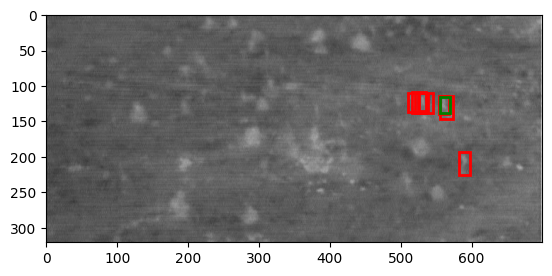

In [ ]:
# Loop through a batch in val_dl
for data in val_dl:
    imgs = [d[0].to(device) for d in data]
    targets = [{'boxes': d[1]['boxes'], 'labels': d[1]['labels']} for d in data]

    # Get predictions
    predictions = model(imgs)

    # Visualize the first image in the batch
    image = imgs[0].cpu().permute(1, 2, 0).numpy()  # Convert tensor to NumPy image
    pred_boxes = predictions[0]['boxes'].cpu().detach().numpy()
    gt_boxes = targets[0]['boxes'].cpu().numpy()

    # Format data for visualization
    pred_data = {'boxes': pred_boxes}
    gt_data = {'boxes': gt_boxes}

    visualize_predictions(image, pred_data, gt_data)
    break


In [ ]:
def calculate_metrics(results):
    """
    Calculate precision, recall, and mAP from the results dictionary.

    Args:
        results: Dictionary containing 'tp', 'fp', and 'fn'.

    Returns:
        precision, recall, mAP
    """
    tp = len(results['tp'])
    fp = len(results['fp'])
    fn = len(results['fn'])

    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Example: Use a placeholder for mAP (custom calculation can be added here)
    # mAP is computed across all IoU thresholds and all classes
    mAP = precision * recall  # Placeholder formula for demo purposes

    return precision, recall, mAP

# Compute metrics
precision, recall, mAP = calculate_metrics(results)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"mAP: {mAP:.4f}")


Precision: 0.1072
Recall: 0.5198
mAP: 0.0557


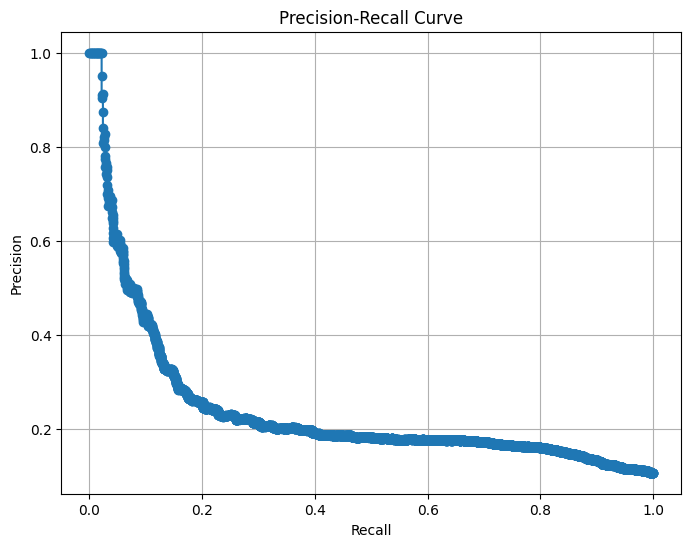

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Example data: Use scores and true/false indicators for predictions
scores = [score for score, _ in results['tp']] + results['fp']
labels = [1] * len(results['tp']) + [0] * len(results['fp'])

precision, recall, _ = precision_recall_curve(labels, scores)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


Extracted all files to /content
32


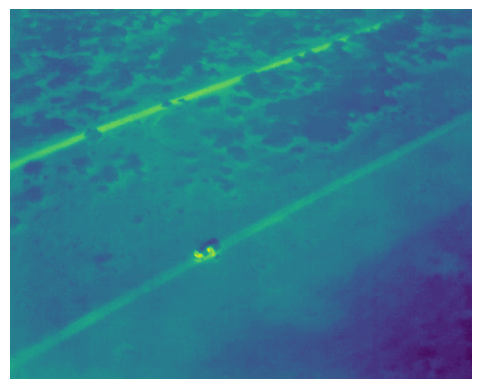

In [ ]:
import zipfile
import os
import pandas as pd
from glob import glob
from PIL import Image
import torch
import torchvision
import torchvision.transforms as T

# Path to the zip file and directory where files will be extracted
zip_file_path = '/content/conservation_drones_train_real.zip'
extract_dir = '/content'

# Create the directory if it doesn't exist and extract the files
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted all files to {extract_dir}")

# Load CSV annotations into a DataFrame
csv_path = '/content/TrainReal/annotations/0000000010_0000000000.csv'
df = pd.read_csv(csv_path, header=None)
df.head()

# Collect all CSV file paths
csvs = glob('/content/TrainReal/annotations/*.csv')
print(len(csvs))

# Initialize the dataframe to hold all annotations
df = pd.DataFrame(columns=['frame_number', 'object_id', 'x', 'y', 'w', 'h', 'class', 'species', 'occlusion', 'noise', 'image_path'], data=None)

# Process all CSVs and create the dataframe with image paths
for csv in csvs:
    temp = pd.read_csv(csv, header=None, names=['frame_number', 'object_id', 'x', 'y', 'w', 'h', 'class', 'species', 'occlusion', 'noise'])
    base_path = '/content/TrainReal/images'
    paths = []
    frame_num = csv.split('/')[-1].split('.')[0]
    for idx in temp.index:
        frame_id = str(temp.iloc[idx]['frame_number']).zfill(10)
        path = f"{base_path}/{frame_num}/{frame_num}_{frame_id}.jpg"
        paths.append(path)
    temp['image_path'] = paths
    df = pd.concat([df, temp], axis=0)

# Show first few rows to verify
df.head()

# Save the annotations DataFrame to CSV for future use
df.to_csv('annotations.csv', index=False)
df = pd.read_csv('annotations.csv')

# Convert the bounding box columns to numeric and calculate x1, y1 (bottom-right coordinates)
df['x'] = pd.to_numeric(df['x'])
df['y'] = pd.to_numeric(df['y'])
df['w'] = pd.to_numeric(df['w'])
df['h'] = pd.to_numeric(df['h'])
df['x1'] = df['x'] + df['w']
df['y1'] = df['y'] + df['h']

# Drop unnecessary columns for model training
#df.drop(['frame_number', 'object_id', 'class', 'w', 'h', 'noise', 'occlusion', 'species'], axis=1, inplace=True)

# Display a sample image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
first_image_path = df['image_path'].iloc[5]
img = mpimg.imread(first_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
# Display dataset size and a few entries
df = df.sample(n=8000, random_state=42)
df.reset_index(drop=True, inplace=True)
df.head()

,frame_number,object_id,x,y,w,h,class,species,occlusion,noise,image_path,x1,y1
0,5160,62,465,131,37,41,0,1,0,0,/content/TrainReal/images/0000000367_000000000...,502,172
1,3239,45,238,182,97,100,0,1,0,0,/content/TrainReal/images/0000000367_000000000...,335,282
2,740,1,542,160,10,13,1,0,0,0,/content/TrainReal/images/0000000067_000000005...,552,173
3,2142,16,0,280,76,41,0,1,0,0,/content/TrainReal/images/0000000367_000000000...,76,321
4,894,74,229,180,10,7,0,3,0,0,/content/TrainReal/images/0000000067_000000004...,239,187


In [ ]:
import torchvision.transforms as T

# Define your transform pipeline with augmentations
transform = T.Compose([
    T.RandomHorizontalFlip(),  # Random horizontal flip
    T.RandomVerticalFlip(),    # Random vertical flip (helps with occlusion)
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter (noise)
    T.RandomRotation(30),      # Random rotation to simulate occlusion
    T.RandomResizedCrop(256, scale=(0.8, 1.0)),  # Random crop with scaling
    T.ToTensor(),  # Convert image to tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])


In [ ]:
class custDat(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        """
        Initialize the dataset with image paths, bounding box, class, species, and occlusion information.
        """
        self.df = df
        self.image_paths = df['image_path'].unique()
        self.transform = transform  # Apply transformations if provided

    def __len__(self):
        """
        Return the number of unique images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Return the image tensor and the target dictionary containing bounding boxes, labels, species, and occlusion.
        """
        # Get image path and bounding boxes
        image_path = self.image_paths[idx]
        boxes = self.df[self.df.image_path == image_path][['x', 'y', 'x1', 'y1']].values.astype("float")

        # Get the class (human or animal) and species
        labels = self.df[self.df.image_path == image_path]['class'].values
        species = self.df[self.df.image_path == image_path]['species'].values

        # Handle occlusion (1 for occluded, 0 for non-occluded)
        occlusion = self.df[self.df.image_path == image_path]['occlusion'].values

        # Open the image
        img = Image.open(image_path).convert('RGB')

        # Apply the transform if provided (augmentation, normalization)
        if self.transform:
            img = self.transform(img)

        # Create the target dictionary
        target = {
            "boxes": torch.tensor(boxes),  # Bounding boxes as tensor
            "labels": torch.tensor(labels),  # Class labels as tensor
            "species": torch.tensor(species),  # Species labels as tensor
            "occlusion": torch.tensor(occlusion)  # Occlusion info
        }

        return img, target


In [ ]:
import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class FasterRCNNWithSpeciesAndOcclusion(nn.Module):
    def __init__(self, num_classes, num_species_classes):
        super(FasterRCNNWithSpeciesAndOcclusion, self).__init__()
        self.fasterrcnn = fasterrcnn_resnet50_fpn(pretrained=True)

        # Modify the classifier for class prediction (human/animal)
        in_features = self.fasterrcnn.roi_heads.box_predictor.cls_score.in_features
        self.fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # Add an additional head for species prediction
        self.fasterrcnn.roi_heads.species_predictor = nn.Linear(in_features, num_species_classes)

    def forward(self, images, targets=None):
        losses = self.fasterrcnn(images, targets)
        if self.training:
            species_logits = self.fasterrcnn.roi_heads.species_predictor(self.fasterrcnn.roi_heads.box_predictor.cls_score)
            losses["species_loss"] = self._compute_species_loss(species_logits, targets)
            losses["occlusion_loss"] = self._compute_occlusion_loss(targets)
        return losses

    def _compute_species_loss(self, species_logits, targets):
        species_gt = [target["species"] for target in targets]
        species_loss = nn.CrossEntropyLoss()(species_logits, torch.cat(species_gt))
        return species_loss

    def _compute_occlusion_loss(self, targets):
        occlusion_loss = 0
        for target in targets:
            occlusion = target['occlusion']
            occlusion_loss += (occlusion == 1).sum()  # Higher loss for occluded objects
        return occlusion_loss

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Split the dataset into train and validation sets
image_paths = df['image_path'].unique()
train_paths, val_paths = train_test_split(image_paths, test_size=0.1)

# Create custom datasets for training and validation
train_dataset = custDat(df[df['image_path'].isin(train_paths)], transform=transform)
val_dataset = custDat(df[df['image_path'].isin(val_paths)], transform=transform)

# Create DataLoader instances
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_dl = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Initialize the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = FasterRCNNWithSpeciesAndOcclusion(num_classes=2, num_species_classes=9).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

# Train the model for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    epoch_loss = 0
    for data in train_dl:
        imgs = [d[0].to(device) for d in data]
        targets = [{'boxes': d[1]['boxes'].to(device), 'labels': d[1]['labels'].to(device),
                    'species': d[1]['species'].to(device), 'occlusion': d[1]['occlusion'].to(device)} for d in data]

        # Forward pass through the model
        loss_dict = model(imgs, targets)

        # Sum the losses
        total_loss = sum(loss for loss in loss_dict.values())
        epoch_loss += total_loss.item()

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")


In [ ]:
def predict_with_species_and_occlusion(model, image, device):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        prediction = model([image])

        pred_classes = prediction[0]['labels']
        pred_species = prediction[0]['species']
        pred_boxes = prediction[0]['boxes']

        # Filter out occluded objects (occlusion == 1)
        occluded = prediction[0]['occlusion'] == 1
        pred_classes = pred_classes[~occluded]
        pred_species = pred_species[~occluded]
        pred_boxes = pred_boxes[~occluded]

        return pred_classes, pred_species, pred_boxes
